In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import time
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

import tensorflow.keras as keras

Mounted at /content/drive


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Step 0, Loss: 94366480.0
Step 100, Loss: 70287880.0
Step 200, Loss: 48125204.0
Step 300, Loss: 32454876.0
Step 400, Loss: 23193434.0
Step 500, Loss: 17609862.0
Step 600, Loss: 13827689.0
Step 700, Loss: 11055697.0
Step 800, Loss: 8984680.0
Step 900, Loss: 7435010.0
Step 1000, Loss: 6274031.0
Step 1100, Loss: 5395691.0
Step 1200, Loss: 4722833.5
Step 1300, Loss: 4197681.0
Step 1400, Loss: 3777466.25
Step 1500, Loss: 3433802.0
Step 1600, Loss: 3146420.0
Step 1700, Loss: 2901847.5
Step 1800, Loss: 2691037.25
Step 1900, Loss: 2507553.5
Step 2000, Loss: 2345887.25
Step 2100, Loss: 2202302.0
Step 2200, Loss: 2073585.75
Step 2300, Loss: 1957536.125
Step 2400, Loss: 1853174.25
Step 2500, Loss: 1758825.75
Step 2600, Loss: 1672603.25
Step 2700, Loss: 1593373.5
Step 2800, Loss: 1520566.125
Step 2900, Loss: 1453297.0
Step 3000, Loss: 1390637.0
Step 3100, Loss: 1331967.875
Step 3200, Loss: 1276734.125
Step 3300, Loss: 1224744.5
Step 3400, Loss: 117

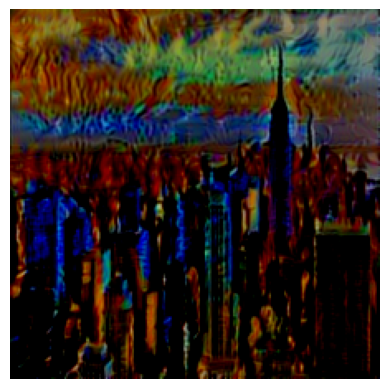

In [2]:
# Load and preprocess the images
content_image_path = '/content/drive/My Drive/Colab Notebooks/projects/artistic_style_transfer/content_image-1.jpg'
style_image_path = '/content/drive/My Drive/Colab Notebooks/projects/artistic_style_transfer/style_image-1.jpg'

# Function to preprocess image for VGG16
def load_and_process_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# Load VGG16 model
vgg = VGG16(weights='imagenet', include_top=False)

# Extracting low-level features for style and high-level features for content
low_level_layers = ['block1_conv1', 'block2_conv1']
low_level_outputs = [vgg.get_layer(layer).output for layer in low_level_layers]
style_model = Model(inputs=vgg.input, outputs=low_level_outputs)
low_level_features = style_model(style_image)

high_level_layers = ['block5_conv2', 'block5_conv3']
high_level_outputs = [vgg.get_layer(layer).output for layer in high_level_layers]
content_model = Model(inputs=vgg.input, outputs=high_level_outputs)
high_level_features = content_model(content_image)

# Initialize combination image with content
combination_image = tf.Variable(content_image, dtype=tf.float32)

# Function to calculate Gram matrix for style loss
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    tensor = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tensor, tensor, transpose_a=True)
    return gram / tf.cast(tf.shape(tensor)[0], tf.float32)

# Updated loss functions to handle lists of features
def content_loss(content_features, combination_features):
    # Compute the mean of squared differences for each layer's features and sum them
    return tf.reduce_sum([tf.reduce_mean(tf.square(c - comb)) for c, comb in zip(content_features, combination_features)])

def style_loss(style_features, combination_features):
    # Compute the mean of squared differences of Gram matrices and sum them
    return tf.reduce_sum([tf.reduce_mean(tf.square(gram_matrix(s) - gram_matrix(comb))) for s, comb in zip(style_features, combination_features)])

def total_variation_loss(image):
    a = tf.square(image[:, :-1, :-1, :] - image[:, 1:, :-1, :])
    b = tf.square(image[:, :-1, :-1, :] - image[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Total loss function combining content, style, and total variation losses
def total_loss(content_features, style_features, comb_content_features, comb_style_features, combination_image, content_weight, style_weight, variation_weight):
    content_loss_value = content_loss(content_features, comb_content_features)
    style_loss_value = style_loss(style_features, comb_style_features)
    variation_loss_value = total_variation_loss(combination_image)
    return (content_weight * content_loss_value +
            style_weight * style_loss_value +
            variation_weight * variation_loss_value)

# Weights for losses
content_weight = 1e3
style_weight = 1e-2
variation_weight = 1e-4

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.05)

# Optimization loop
epochs = 10000
for i in range(epochs):
    with tf.GradientTape() as tape:
        comb_content_features = content_model(combination_image)
        comb_style_features = style_model(combination_image)
        loss = total_loss(high_level_features, low_level_features, comb_content_features, comb_style_features, combination_image, content_weight, style_weight, variation_weight)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        print(f'Step {i}, Loss: {loss.numpy()}')

# Display final image
def display_image(image_tensor):
    img = image_tensor.numpy().squeeze()
    img = np.clip(img, 0, 255).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(combination_image)

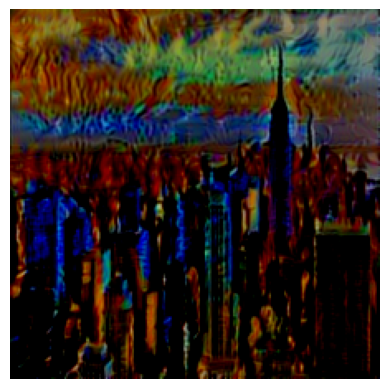

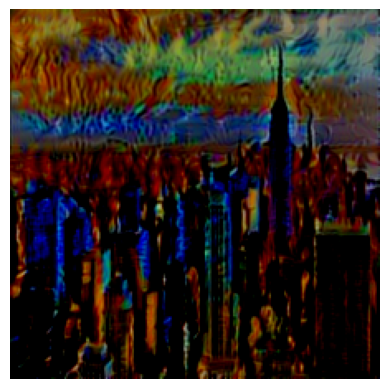

In [3]:
# Display final image
def display_image(image_tensor):
    img = image_tensor.numpy().squeeze()
    img = np.clip(img, 0, 255).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(combination_image)

# Display final image
display_image(combination_image)